In [4]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=0065a6fa95a560cf3d63efd5a73fc2b7e5bac53bbb7b555360773b3255422aea
  Stored in directory: /Users/kyusungcho/Library/Caches/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel('Cancer patient data.xlsx')
df

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,1948-11-28,NaT,Male,More than one Race,0,0,1,0,0,NaT,NaT,2015-02-06,NaT,NaT
8464,1938-07-05,NaT,Female,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8465,1958-06-05,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8466,1955-12-29,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,2013-01-06


# Data Preprocessing

In [6]:
print("Initial patient counts:")
for cancer in ['LUNG', 'PANCREAS', 'THYROID', 'COLORECTAL', 'MELANOMA']:
    print(f"{cancer}: {df[cancer].sum()} patients")

Initial patient counts:
LUNG: 1485 patients
PANCREAS: 660 patients
THYROID: 745 patients
COLORECTAL: 948 patients
MELANOMA: 348 patients


In [8]:
cancer_dt_cols = {
    'LUNG': 'LUNG DT',
    'PANCREAS': 'PANCREAS_DT',
    'THYROID': 'THYROID_DT',
    'COLORECTAL': 'COLORECTAL_DT',
    'MELANOMA': 'MELANOMA_DT'
}

date_cols = ['BIRTH_DATE_off', 'DEATH_DATE_off'] + list(cancer_dt_cols.values())
for col in date_cols:
    df[col] = pd.to_datetime(df[col].replace({'#N/A': None}), errors='coerce')

print("After date conversion:")
for cancer in cancer_dt_cols.keys():
    print(f"{cancer}: {df[cancer].sum()} patients")

After date conversion:
LUNG: 1485 patients
PANCREAS: 660 patients
THYROID: 745 patients
COLORECTAL: 948 patients
MELANOMA: 348 patients


In [10]:
cancer_types = list(cancer_dt_cols.keys())
end_date = pd.to_datetime('2016-08-25')

print("Removing diagnoses after 8/25/16:")
for cancer, dt_col in cancer_dt_cols.items():
    before_count = df[cancer].sum()
    mask = (df[dt_col] > end_date) | pd.isna(df[dt_col])
    df.loc[mask, cancer] = 0
    df.loc[mask, dt_col] = pd.NaT
    after_count = df[cancer].sum()
    dropped = before_count - after_count
    print(f"{cancer}: {before_count} -> {after_count} (dropped: {dropped})")


Removing diagnoses after 8/25/16:
LUNG: 1485 -> 1483 (dropped: 2)
PANCREAS: 660 -> 658 (dropped: 2)
THYROID: 745 -> 744 (dropped: 1)
COLORECTAL: 948 -> 946 (dropped: 2)
MELANOMA: 348 -> 346 (dropped: 2)


In [12]:
print("Censoring deaths after 8/25/16:")
before_null = df['DEATH_DATE_off'].isna().sum()
mask = df['DEATH_DATE_off'] > end_date
df.loc[mask, 'DEATH_DATE_off'] = None
after_null = df['DEATH_DATE_off'].isna().sum()
print(f"Patients censored: {after_null - before_null}")

Censoring deaths after 8/25/16:
Patients censored: 47


In [14]:
print("Removing patients without diagnosis date:")
for cancer, dt_col in cancer_dt_cols.items():
    before_count = df[cancer].sum()
    mask = df[cancer] == 1
    df.loc[mask & df[dt_col].isna(), cancer] = 0
    after_count = df[cancer].sum()
    dropped = before_count - after_count
    print(f"{cancer}: {before_count} -> {after_count} (dropped: {dropped})")


Removing patients without diagnosis date:
LUNG: 1483 -> 1483 (dropped: 0)
PANCREAS: 658 -> 658 (dropped: 0)
THYROID: 744 -> 744 (dropped: 0)
COLORECTAL: 946 -> 946 (dropped: 0)
MELANOMA: 346 -> 346 (dropped: 0)


In [16]:
race_mapping = {
    'White': 'White',
    'Black/African-American': 'African-American',
    'Asian/Mideast Indian': 'Asian/Mideast-Indian'
}
df['race'] = df['race'].map(race_mapping).fillna('Others')


In [18]:
for cancer, dt_col in cancer_dt_cols.items():
    age_col = f'{cancer}_age'
    df[age_col] = (df[dt_col] - df['BIRTH_DATE_off']).dt.days / 365
    
    age_group_col = f'{cancer}_age_group'
    df[age_group_col] = pd.cut(
        df[age_col],
        bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        labels=['11-20', '21-30', '31-40', '41-50', '51-60', 
                '61-70', '71-80', '81-90', '91-100']
    )

In [20]:
print("Final dataset after survival time calculation:")
cancer_data = {}
for cancer in cancer_dt_cols.keys():
    before_count = df[cancer].sum()
    patients = df[df[cancer] == 1].copy()
    
    if len(patients) > 0:
        patients['duration'] = np.where(
            patients['DEATH_DATE_off'].isna(),
            (end_date - patients[cancer_dt_cols[cancer]]).dt.days,
            (patients['DEATH_DATE_off'] - patients[cancer_dt_cols[cancer]]).dt.days
        )
        patients['event'] = (~patients['DEATH_DATE_off'].isna()).astype(int)
        patients = patients[patients['duration'] >= 0]
        cancer_data[cancer] = patients
        
        dropped = before_count - len(patients)
        print(f"{cancer}: {before_count} -> {len(patients)} (dropped due to negative duration: {dropped})")


Final dataset after survival time calculation:
LUNG: 1483 -> 1482 (dropped due to negative duration: 1)
PANCREAS: 658 -> 658 (dropped due to negative duration: 0)
THYROID: 744 -> 744 (dropped due to negative duration: 0)
COLORECTAL: 946 -> 946 (dropped due to negative duration: 0)
MELANOMA: 346 -> 346 (dropped due to negative duration: 0)


In [22]:
print("Final Summary:")
for cancer in cancer_types:
    print(f"\n{cancer} Cancer:")
    print(f"Final number of patients: {len(cancer_data[cancer])}")
    print(f"Deaths: {sum(cancer_data[cancer]['event'])}")
    print(f"Censored: {len(cancer_data[cancer]) - sum(cancer_data[cancer]['event'])}")

Final Summary:

LUNG Cancer:
Final number of patients: 1482
Deaths: 183
Censored: 1299

PANCREAS Cancer:
Final number of patients: 658
Deaths: 33
Censored: 625

THYROID Cancer:
Final number of patients: 744
Deaths: 8
Censored: 736

COLORECTAL Cancer:
Final number of patients: 946
Deaths: 58
Censored: 888

MELANOMA Cancer:
Final number of patients: 346
Deaths: 17
Censored: 329


In [24]:
cancer_data = {}
for cancer in cancer_dt_cols.keys():
    patients = df[df[cancer] == 1].copy()
    
    if len(patients) > 0:
        patients['duration'] = np.where(
            patients['DEATH_DATE_off'].isna(),
            (end_date - patients[cancer_dt_cols[cancer]]).dt.days,
            (patients['DEATH_DATE_off'] - patients[cancer_dt_cols[cancer]]).dt.days
        )
        patients['event'] = (~patients['DEATH_DATE_off'].isna()).astype(int)
        patients = patients[patients['duration'] >= 0]
        cancer_data[cancer] = patients

print("Data Processing Summary:")
for cancer, data in cancer_data.items():
    print(f"\n{cancer} Cancer Statistics:")
    print(f"Total patients: {len(data)}")
    print(f"Deaths: {sum(data['event'])}")
    print(f"Censored: {len(data) - sum(data['event'])}")
    print("\nGender distribution:")
    print(data['sex'].value_counts())
    print("\nRace distribution:")
    print(data['race'].value_counts())
    print("\nAge group distribution:")
    print(data[f'{cancer}_age_group'].value_counts().sort_index())

cancer_counts = df[list(cancer_dt_cols.keys())].sum(axis=1)
multiple_cancers = len(df[cancer_counts > 1])
print(f"Number of patients with multiple cancers: {multiple_cancers}")


Data Processing Summary:

LUNG Cancer Statistics:
Total patients: 1482
Deaths: 183
Censored: 1299

Gender distribution:
sex
Female    764
Male      718
Name: count, dtype: int64

Race distribution:
race
White                   910
African-American        474
Others                   58
Asian/Mideast-Indian     40
Name: count, dtype: int64

Age group distribution:
LUNG_age_group
11-20       4
21-30       6
31-40      15
41-50      74
51-60     299
61-70     497
71-80     428
81-90     148
91-100     10
Name: count, dtype: int64

PANCREAS Cancer Statistics:
Total patients: 658
Deaths: 33
Censored: 625

Gender distribution:
sex
Male      340
Female    318
Name: count, dtype: int64

Race distribution:
race
White                   444
African-American        146
Others                   60
Asian/Mideast-Indian      8
Name: count, dtype: int64

Age group distribution:
PANCREAS_age_group
11-20       0
21-30       3
31-40       9
41-50      30
51-60     135
61-70     221
71-80     177
81-90   

In [26]:
cancer_counts = df[list(cancer_dt_cols.keys())].sum(axis=1)
multiple_cancers = len(df[cancer_counts > 1])
print(f"\nNumber of patients with multiple cancers: {multiple_cancers}")


Number of patients with multiple cancers: 29


# Section A: Survival Curves

In [29]:
def plot_survival_curves(data, group_by=None, title=None, cancer_type=None):
    plt.figure(figsize=(12, 8))
    
    if group_by is None:
        for cancer, patients in data.items():
            if len(patients) > 0:
                kmf = KaplanMeierFitter()
                kmf.fit(patients['duration'], 
                       patients['event'],
                       label=cancer)
                kmf.plot_survival_function()
    else:
        patients = data[cancer_type]
        groups = patients[group_by].unique()
        
        if 'age_group' in group_by:
            age_order = ['11-20', '21-30', '31-40', '41-50', '51-60', 
                        '61-70', '71-80', '81-90', '91-100']
            groups = [g for g in age_order if g in groups]
        
        for group in groups:
            if pd.notna(group):
                mask = patients[group_by] == group
                if mask.sum() > 0:
                    kmf = KaplanMeierFitter()
                    kmf.fit(patients.loc[mask, 'duration'],
                           patients.loc[mask, 'event'],
                           label=str(group))
                    kmf.plot_survival_function()
    
    plt.title(title or 'Cancer Survival Curves')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.legend()
    #plt.xlim(0, 3650) - 10 years
    plt.show()


-Generating overall survival curves for all cancer types-


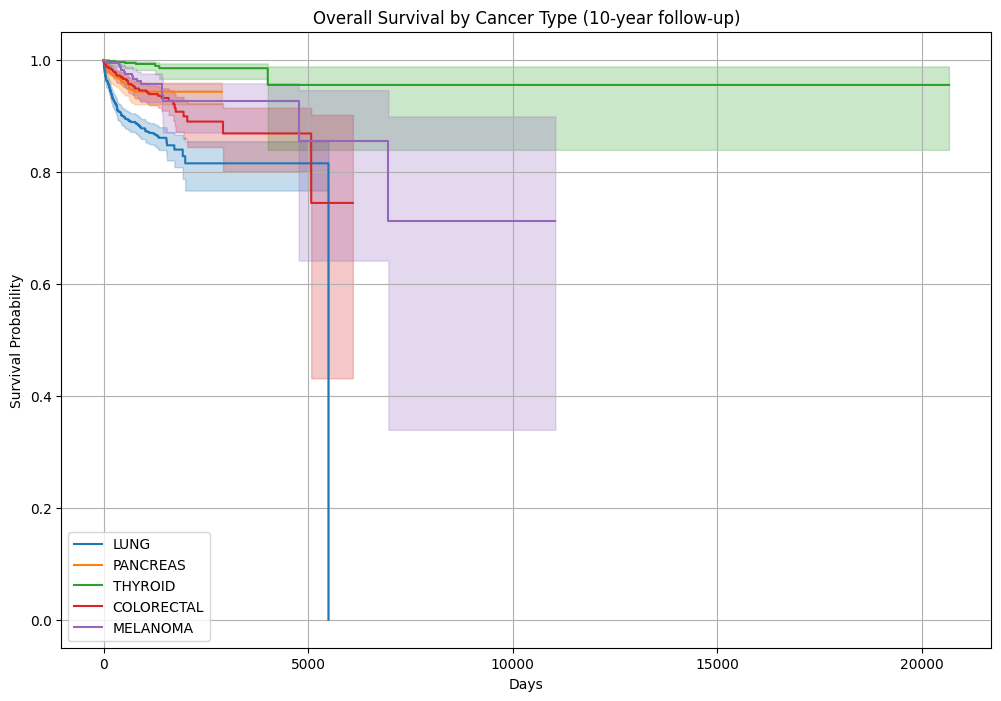

In [31]:
# Overall survival curves
plot_survival_curves(cancer_data, 
                    title='Overall Survival by Cancer Type (10-year follow-up)')


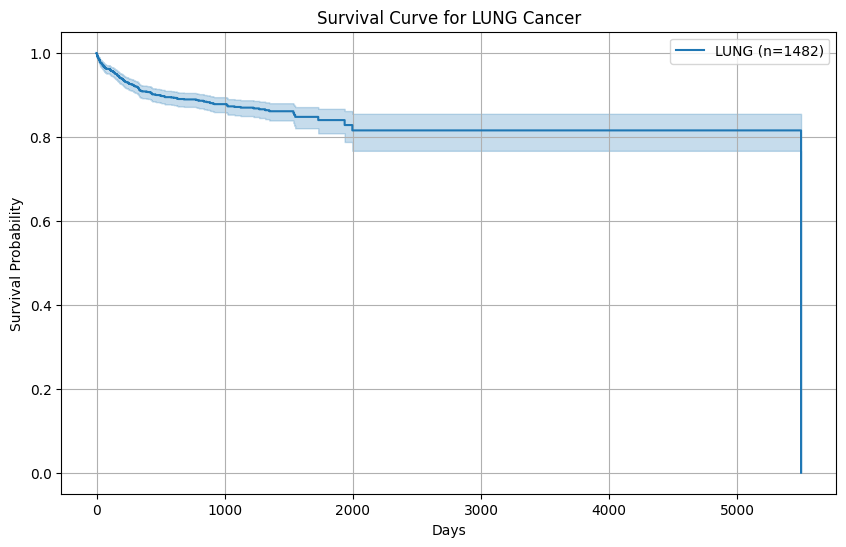

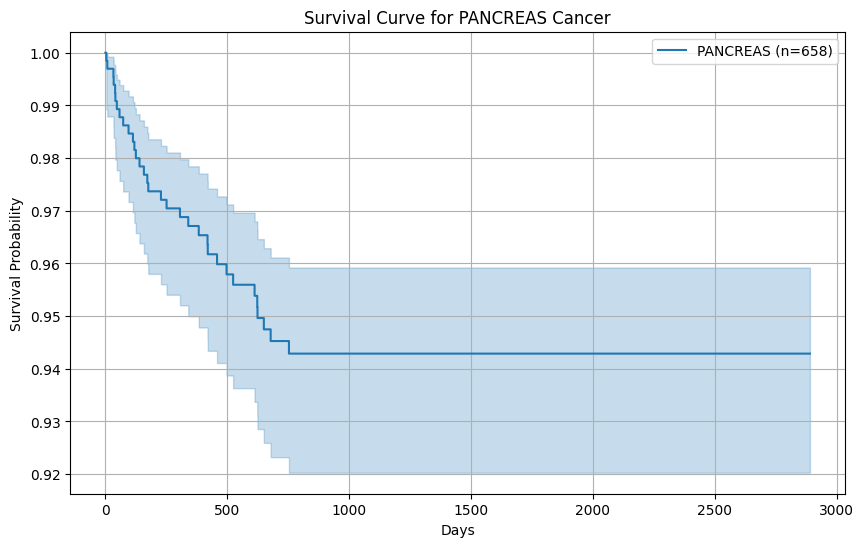

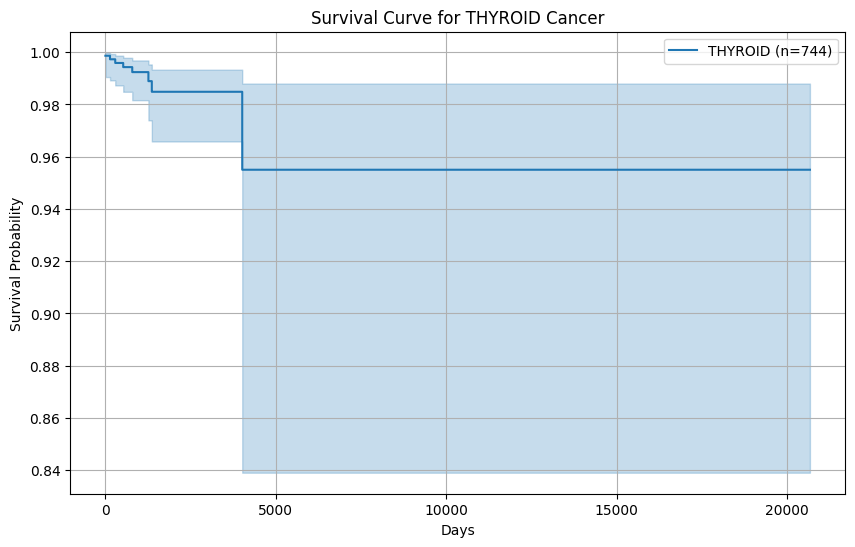

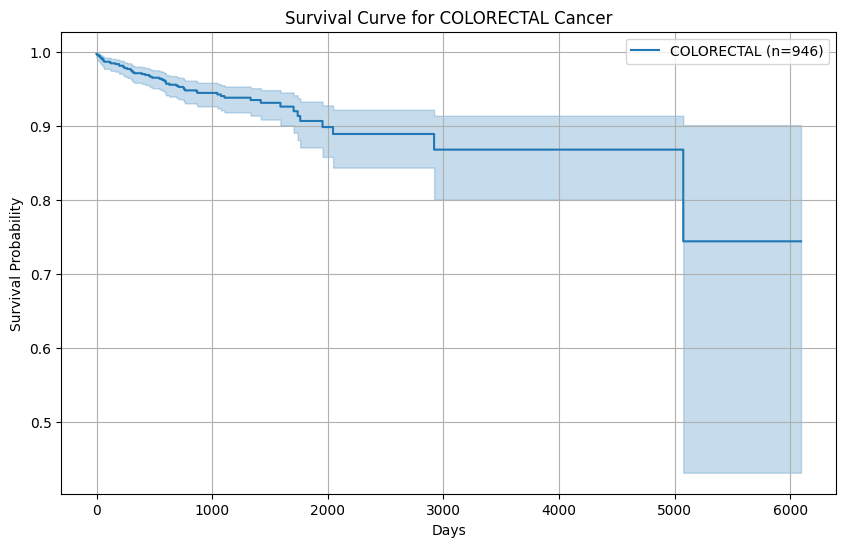

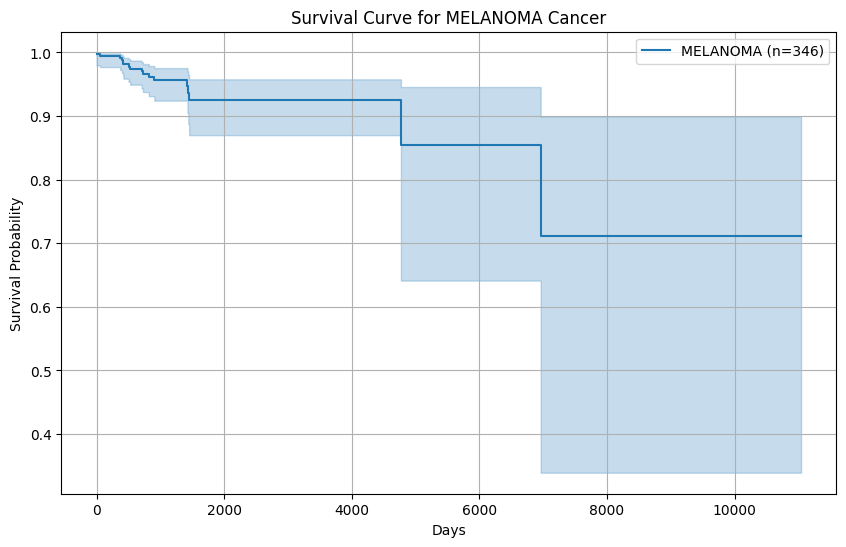

In [33]:
# 1. Cancer types Curves
for cancer in cancer_types:
   if len(cancer_data[cancer]) > 0:
       plt.figure(figsize=(10, 6))
       kmf = KaplanMeierFitter()
       
       patients = cancer_data[cancer]
       kmf.fit(patients['duration'], 
               patients['event'],
               label=f"{cancer} (n={len(patients)})")
       kmf.plot_survival_function(ci_show=True)
       
       plt.title(f'Survival Curve for {cancer} Cancer')
       plt.xlabel('Days')
       plt.ylabel('Survival Probability')
       plt.grid(True)
       plt.show()


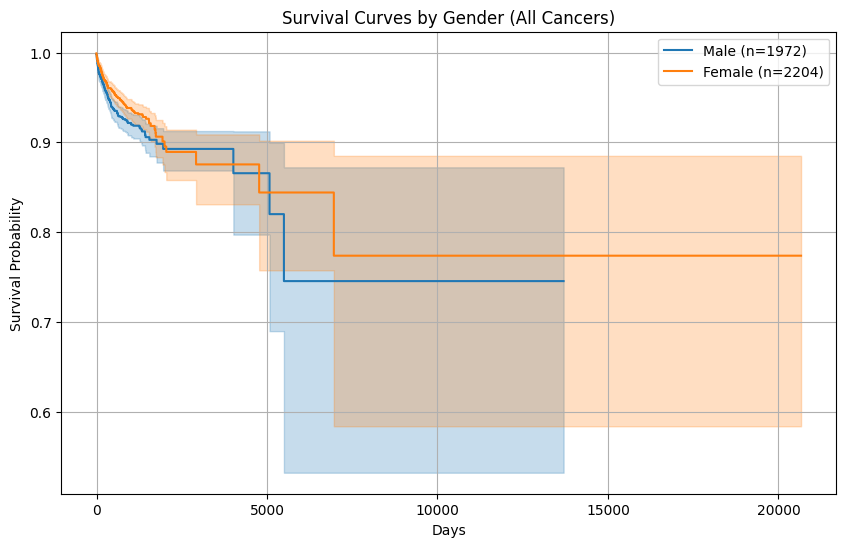

In [35]:
# 2. Gender survival curve
plt.figure(figsize=(10, 6))
all_patients = pd.concat([data for data in cancer_data.values()])
for gender in all_patients['sex'].unique():
   mask = all_patients['sex'] == gender
   if mask.sum() > 0:
       kmf = KaplanMeierFitter()
       kmf.fit(all_patients.loc[mask, 'duration'],
               all_patients.loc[mask, 'event'],
               label=f"{gender} (n={mask.sum()})")
       kmf.plot_survival_function(ci_show=True)

plt.title('Survival Curves by Gender (All Cancers)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

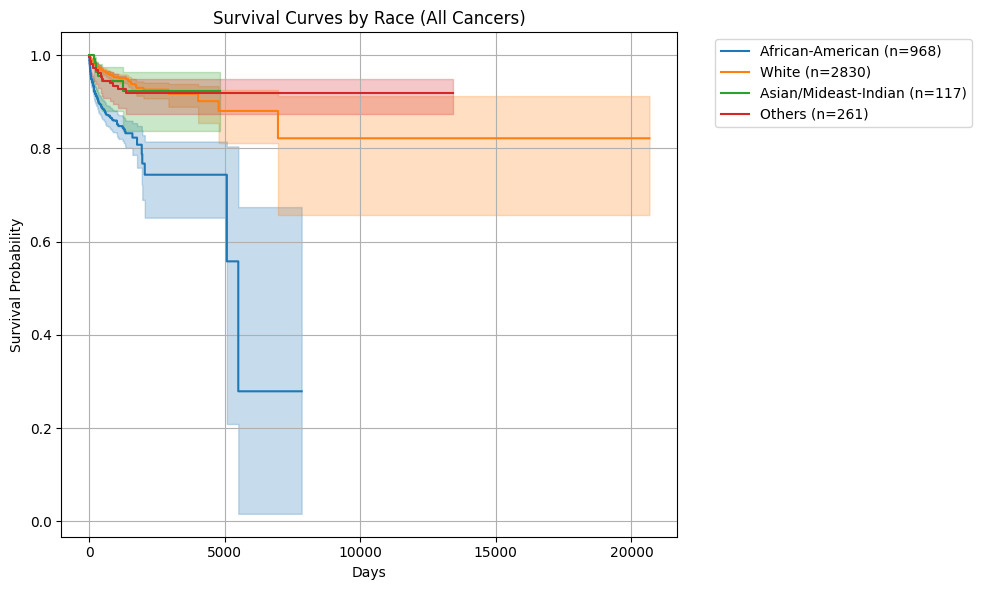

In [37]:
# 3. Race survival curve
plt.figure(figsize=(10, 6))
for race in all_patients['race'].unique():
   mask = all_patients['race'] == race
   if mask.sum() > 0:
       kmf = KaplanMeierFitter()
       kmf.fit(all_patients.loc[mask, 'duration'],
               all_patients.loc[mask, 'event'],
               label=f"{race} (n={mask.sum()})")
       kmf.plot_survival_function(ci_show=True)

plt.title('Survival Curves by Race (All Cancers)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

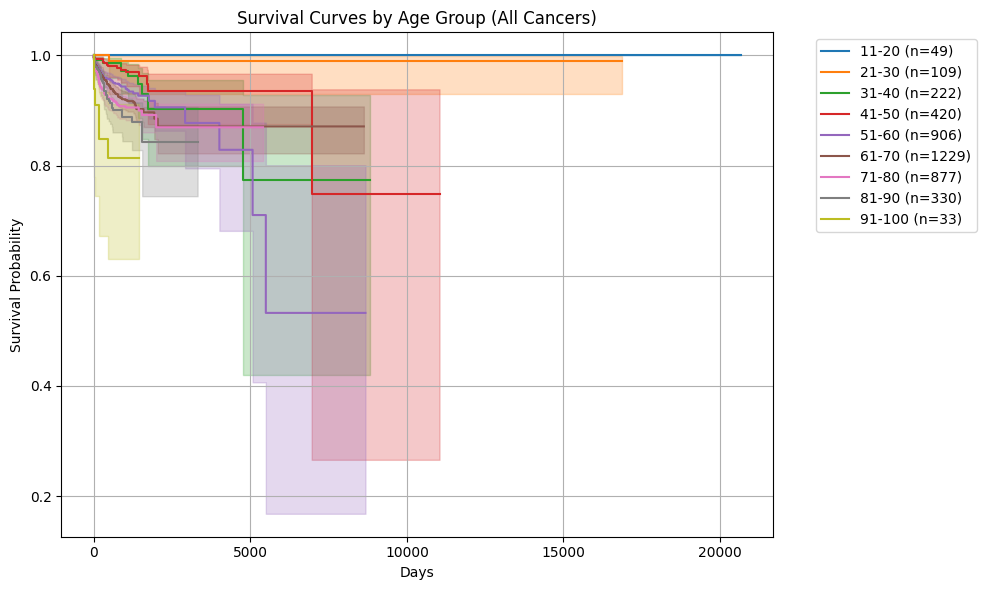

In [39]:
# 4. Age group survival curve
plt.figure(figsize=(10, 6))

age_order = ['11-20', '21-30', '31-40', '41-50', '51-60', 
             '61-70', '71-80', '81-90', '91-100']

age_groups = set()
for cancer in cancer_types:
    age_groups.update(set(cancer_data[cancer][f'{cancer}_age_group'].dropna()))
age_groups = [ag for ag in age_order if ag in age_groups]

for age_group in age_groups:
    temp_patients = pd.DataFrame()
    for cancer in cancer_types:
        mask = cancer_data[cancer][f'{cancer}_age_group'] == age_group
        if mask.sum() > 0:
            temp_patients = pd.concat([temp_patients, cancer_data[cancer][mask]])
            
    if len(temp_patients) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(temp_patients['duration'],
               temp_patients['event'],
               label=f"{age_group} (n={len(temp_patients)})")
        kmf.plot_survival_function(ci_show=True)

plt.title('Survival Curves by Age Group (All Cancers)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
def plot_survival_curves(data, group_by=None, title=None, cancer_type=None, combined=False):
    plt.figure(figsize=(12, 8))
    
    if combined and group_by is not None:
        for cancer, patients in data.items():
            if len(patients) > 0:
                groups = patients[group_by].unique()
                
                if 'age_group' in group_by:
                    age_order = ['11-20', '21-30', '31-40', '41-50', '51-60', 
                                '61-70', '71-80', '81-90', '91-100']
                    groups = [g for g in age_order if g in groups]
                else:
                    groups = sorted(groups)
                
                for group in groups:
                    if pd.notna(group):
                        mask = patients[group_by] == group
                        if mask.sum() > 0:
                            kmf = KaplanMeierFitter()
                            kmf.fit(patients.loc[mask, 'duration'],
                                   patients.loc[mask, 'event'],
                                   label=f"{cancer}-{group}")
                            kmf.plot_survival_function()
    elif group_by is None:
        for cancer, patients in data.items():
            if len(patients) > 0:
                kmf = KaplanMeierFitter()
                kmf.fit(patients['duration'], 
                       patients['event'],
                       label=f"{cancer} (n={len(patients)})")
                kmf.plot_survival_function()
    else:
        patients = data[cancer_type]
        groups = patients[group_by].unique()
        
        if 'age_group' in group_by:
            age_order = ['11-20', '21-30', '31-40', '41-50', '51-60', 
                        '61-70', '71-80', '81-90', '91-100']
            groups = [g for g in age_order if g in groups]
        else:
            groups = sorted(groups)
        
        for group in groups:
            if pd.notna(group):
                mask = patients[group_by] == group
                if mask.sum() > 0:
                    kmf = KaplanMeierFitter()
                    kmf.fit(patients.loc[mask, 'duration'],
                           patients.loc[mask, 'event'],
                           label=f"{group} (n={mask.sum()})")
                    kmf.plot_survival_function()
    
    plt.title(title or 'Cancer Survival Curves')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    if combined or group_by == 'race':
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend()
    plt.tight_layout()
    plt.show()


-Generating survival curves for LUNG cancer-


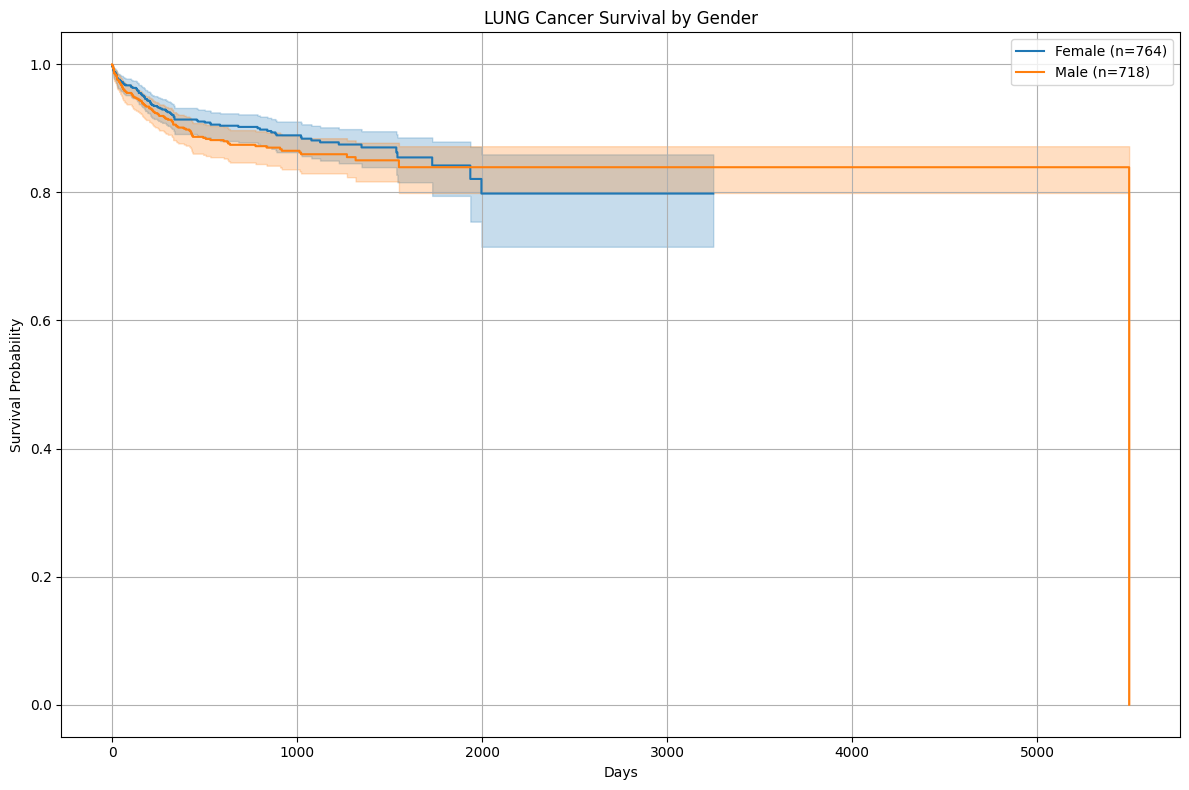

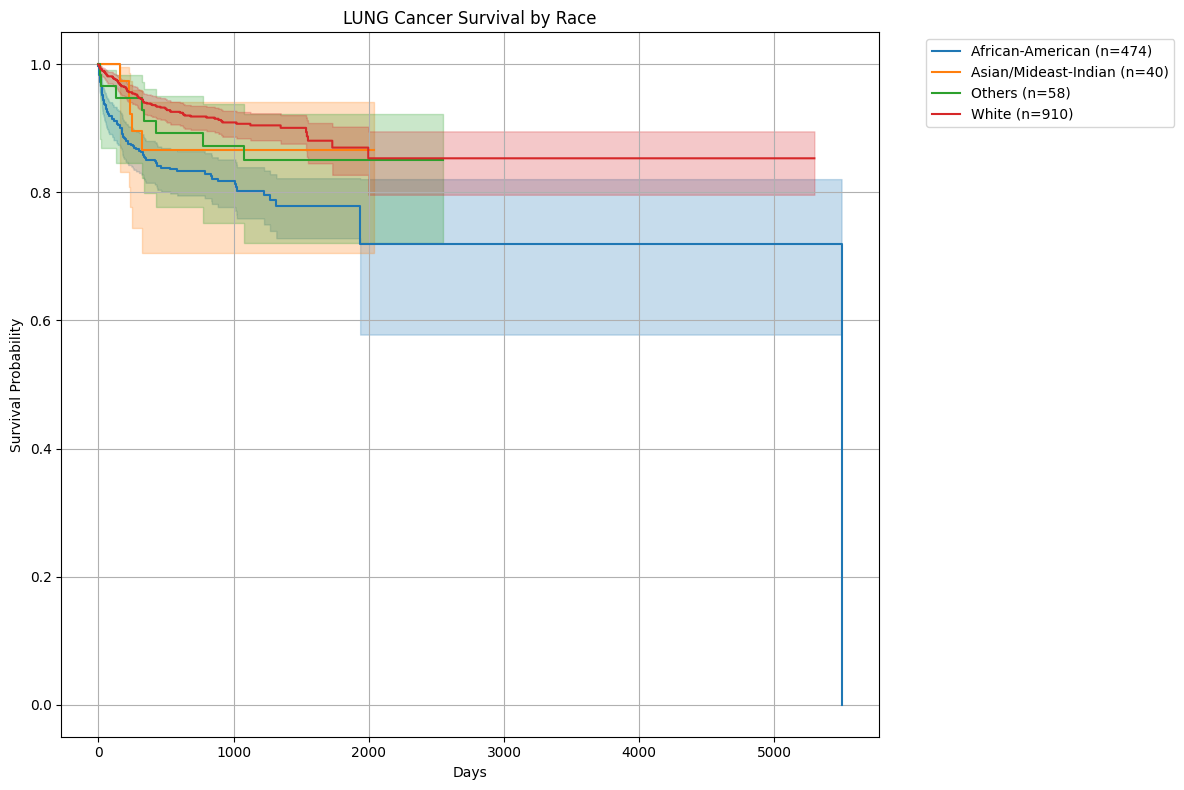

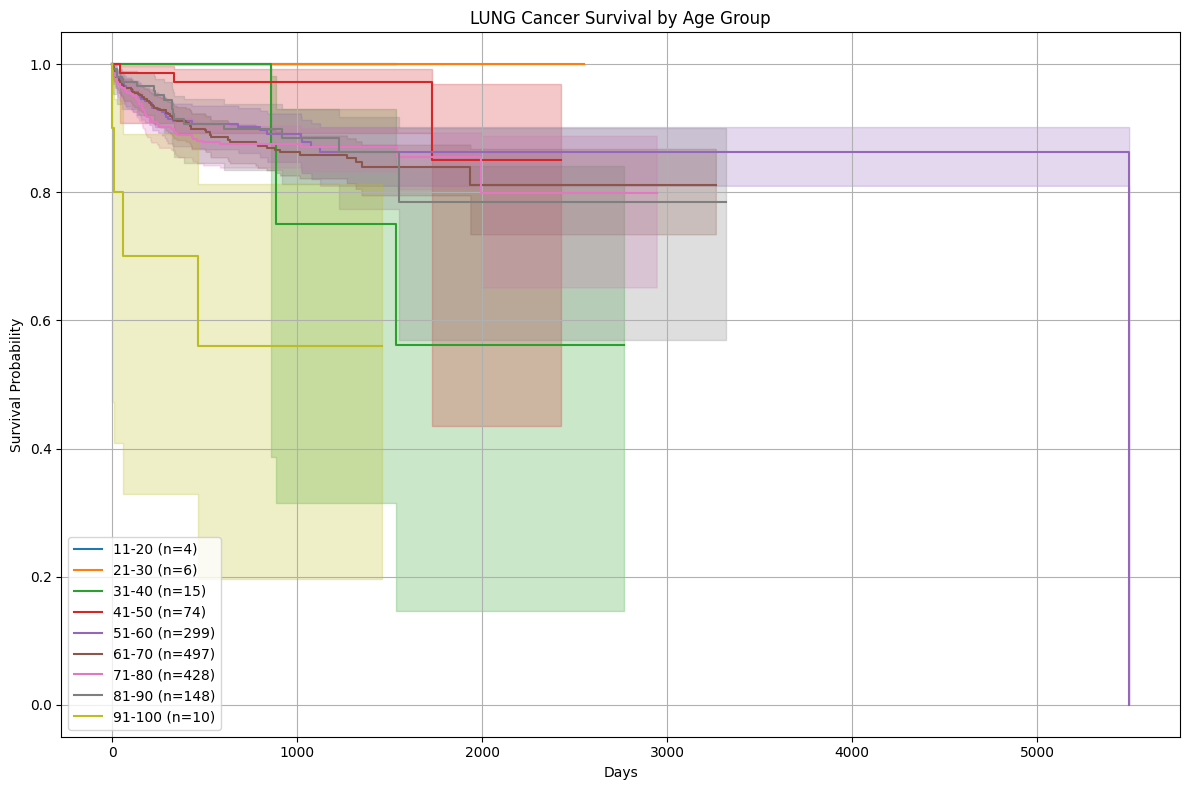


LUNG Cancer Basic Statistics:

Gender Distribution:
sex
Female    764
Male      718
Name: count, dtype: int64

Race Distribution:
race
White                   910
African-American        474
Others                   58
Asian/Mideast-Indian     40
Name: count, dtype: int64

Age Group Distribution:
LUNG_age_group
11-20       4
21-30       6
31-40      15
41-50      74
51-60     299
61-70     497
71-80     428
81-90     148
91-100     10
Name: count, dtype: int64

Survival Statistics:
1-year survival rate: 90.8%
3-year survival rate: 87.1%
5-year survival rate: 84.0%
10-year survival rate: 81.5%
Median survival time: 5497.0 days

Patient Summary:
Total patients: 1482
Number of deaths: 183
Number of censored: 1299

-Generating survival curves for PANCREAS cancer-


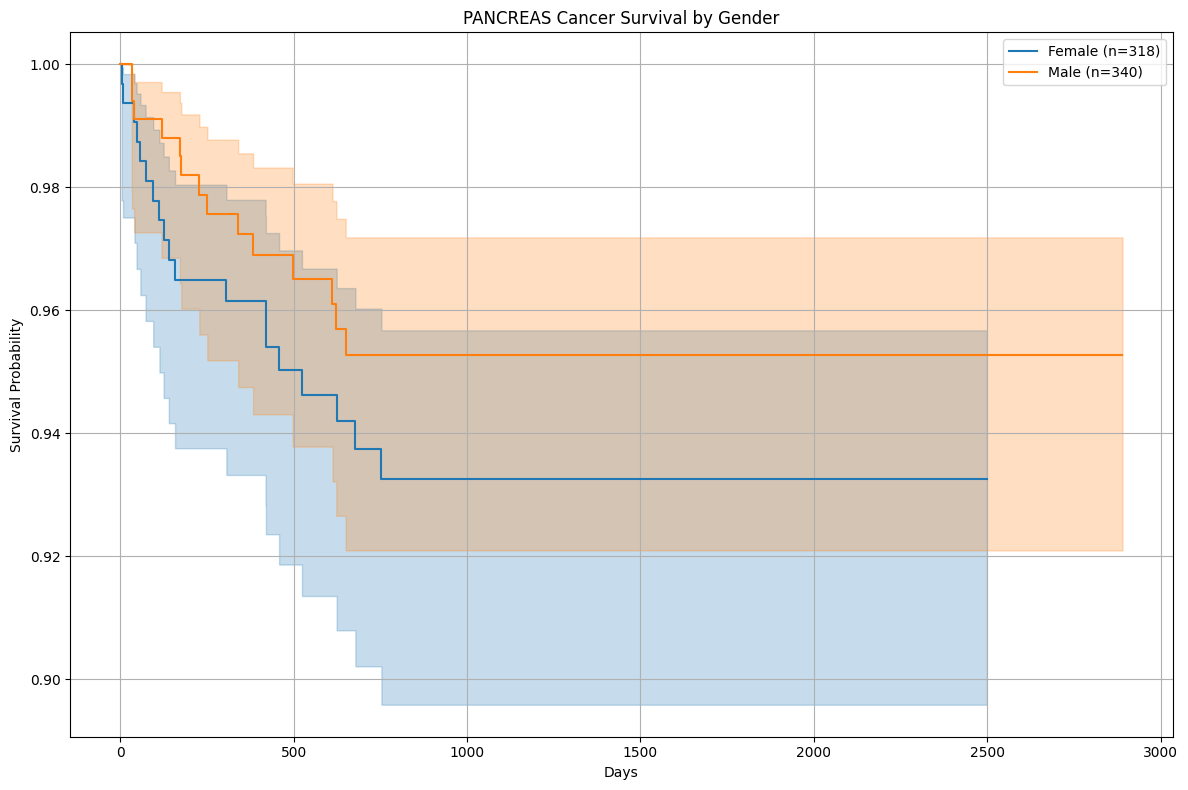

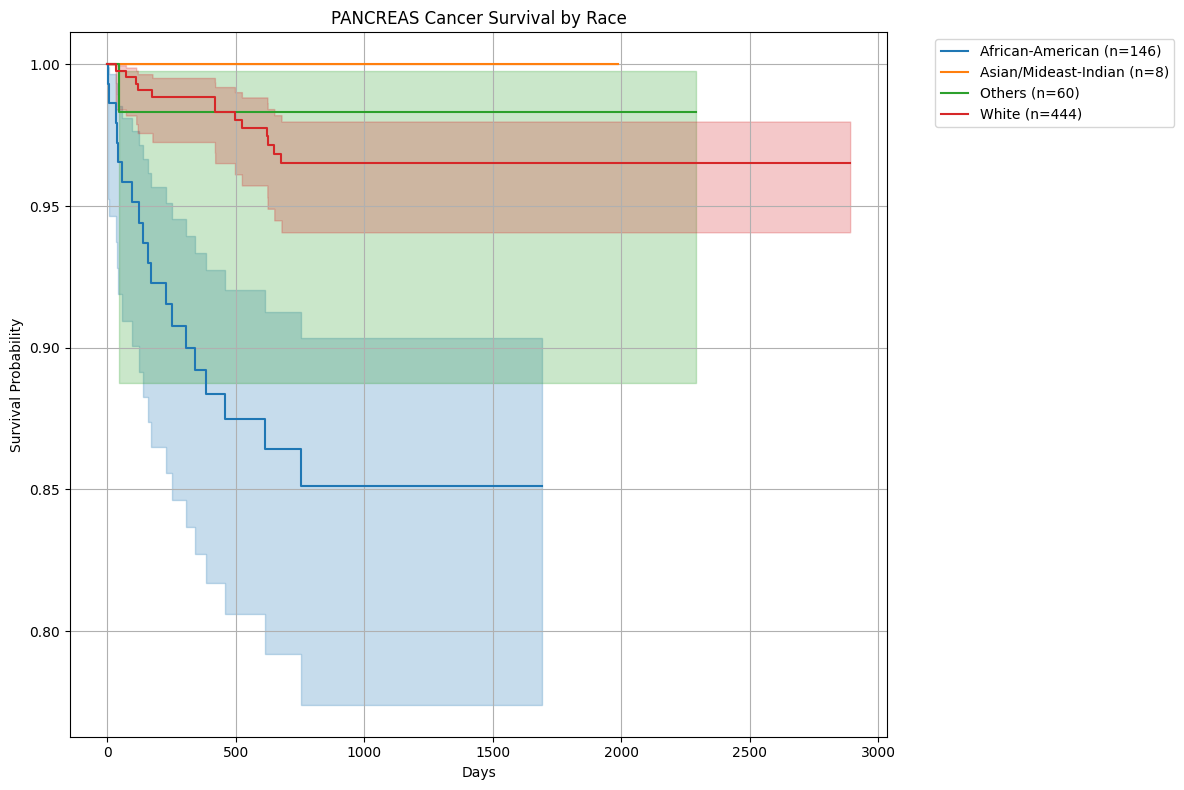

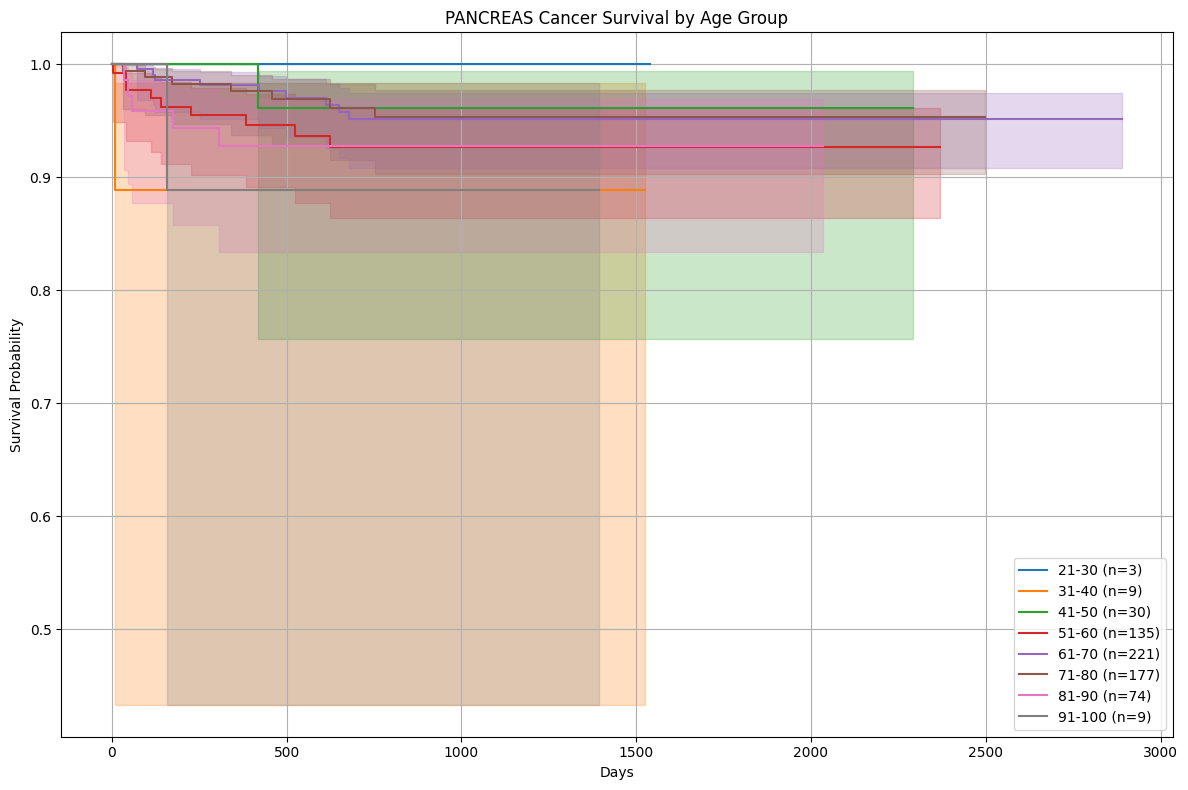


PANCREAS Cancer Basic Statistics:

Gender Distribution:
sex
Male      340
Female    318
Name: count, dtype: int64

Race Distribution:
race
White                   444
African-American        146
Others                   60
Asian/Mideast-Indian      8
Name: count, dtype: int64

Age Group Distribution:
PANCREAS_age_group
11-20       0
21-30       3
31-40       9
41-50      30
51-60     135
61-70     221
71-80     177
81-90      74
91-100      9
Name: count, dtype: int64

Survival Statistics:
1-year survival rate: 96.7%
3-year survival rate: 94.3%
5-year survival rate: 94.3%
10-year survival rate: 94.3%
Median survival time: Not reached (survival > 50%)

Patient Summary:
Total patients: 658
Number of deaths: 33
Number of censored: 625

-Generating survival curves for THYROID cancer-


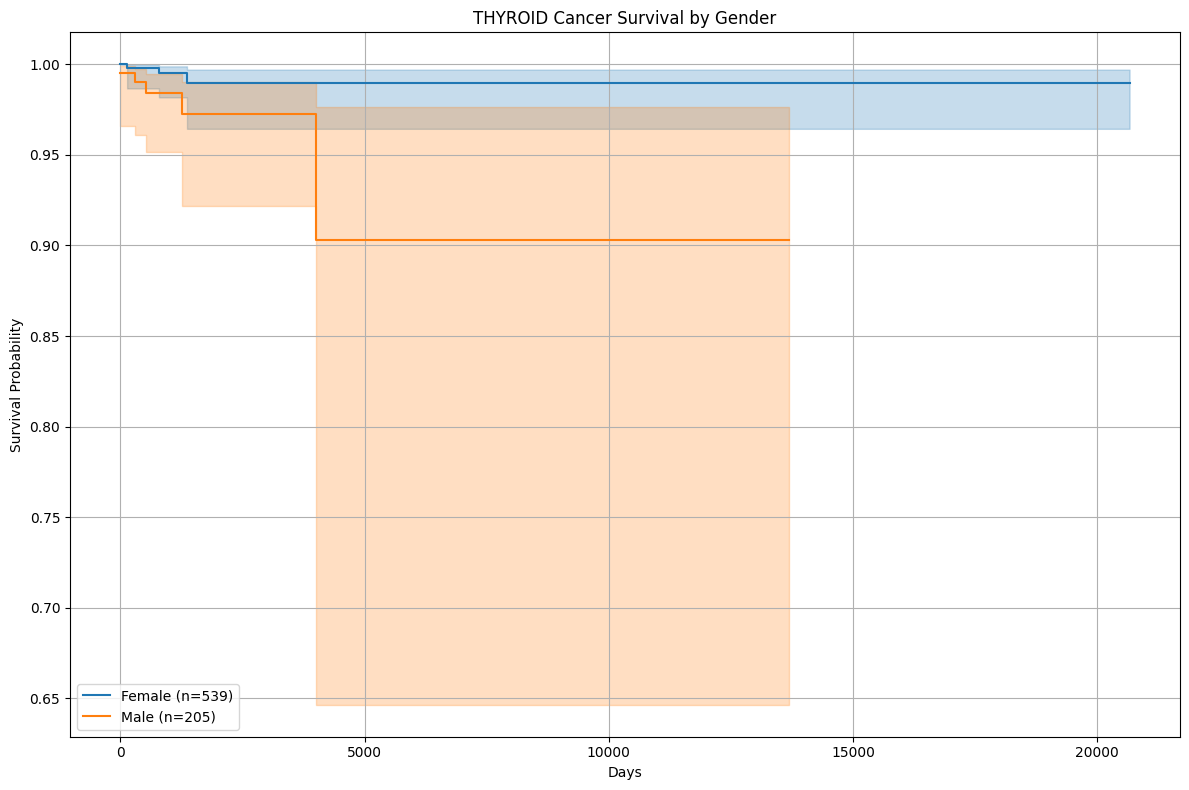

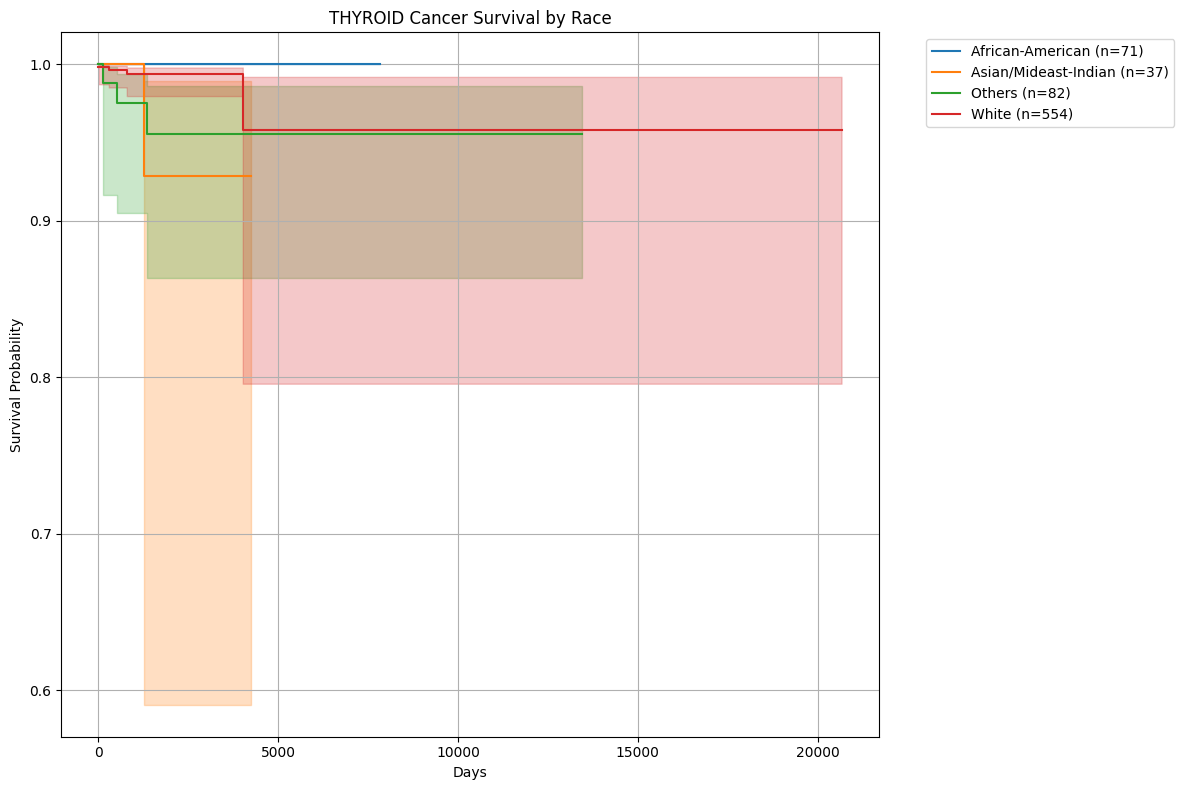

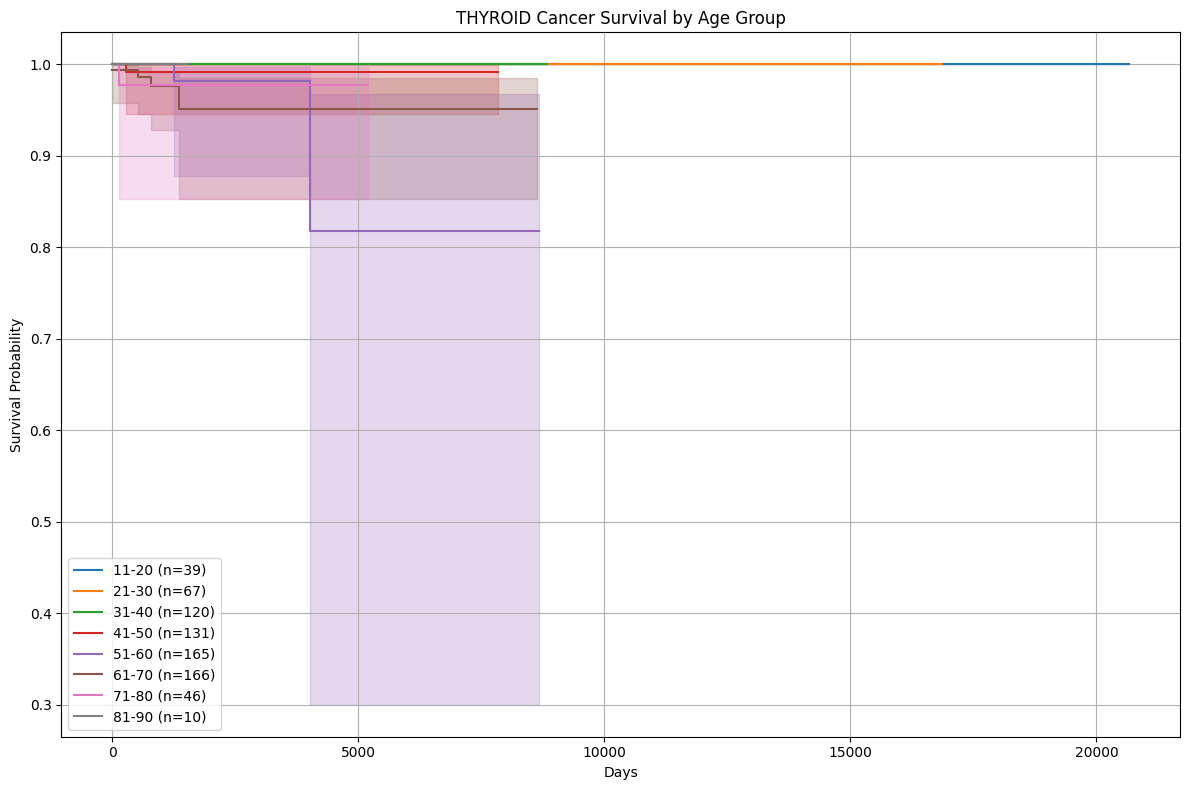


THYROID Cancer Basic Statistics:

Gender Distribution:
sex
Female    539
Male      205
Name: count, dtype: int64

Race Distribution:
race
White                   554
Others                   82
African-American         71
Asian/Mideast-Indian     37
Name: count, dtype: int64

Age Group Distribution:
THYROID_age_group
11-20      39
21-30      67
31-40     120
41-50     131
51-60     165
61-70     166
71-80      46
81-90      10
91-100      0
Name: count, dtype: int64

Survival Statistics:
1-year survival rate: 99.6%
3-year survival rate: 99.2%
5-year survival rate: 98.5%
10-year survival rate: 98.5%
Median survival time: Not reached (survival > 50%)

Patient Summary:
Total patients: 744
Number of deaths: 8
Number of censored: 736

-Generating survival curves for COLORECTAL cancer-


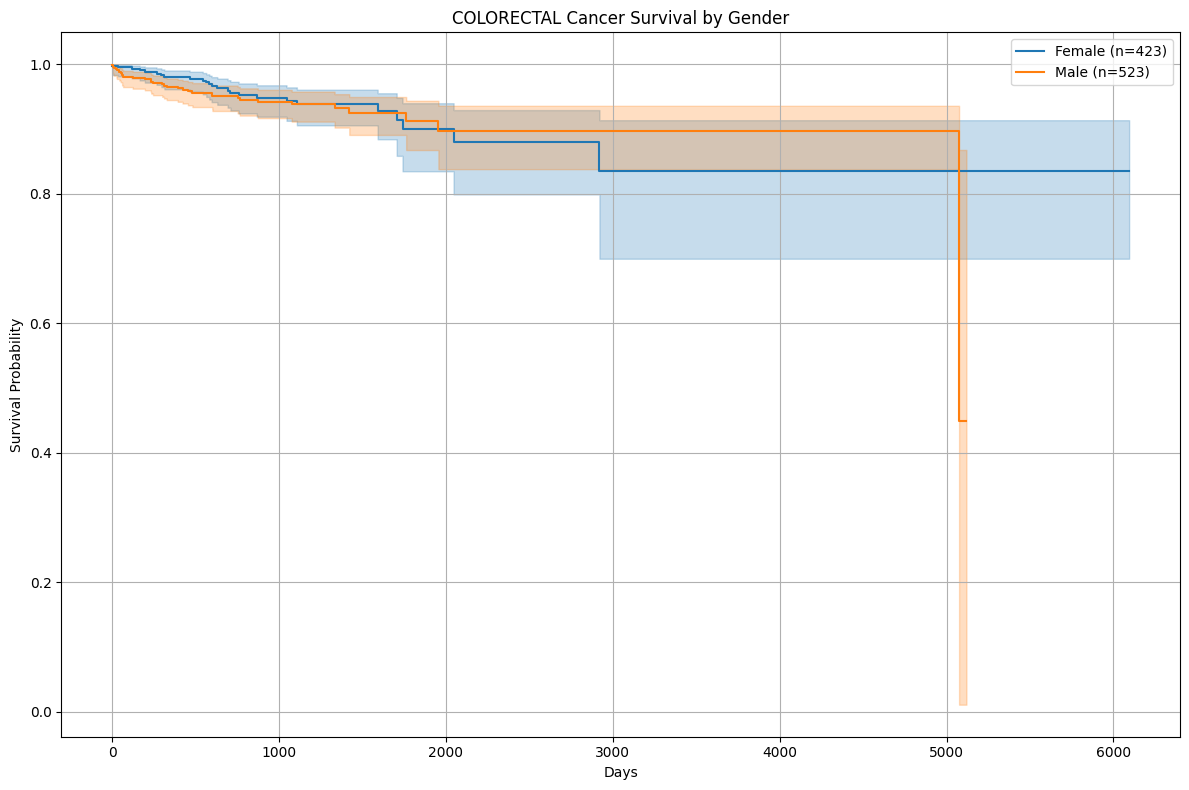

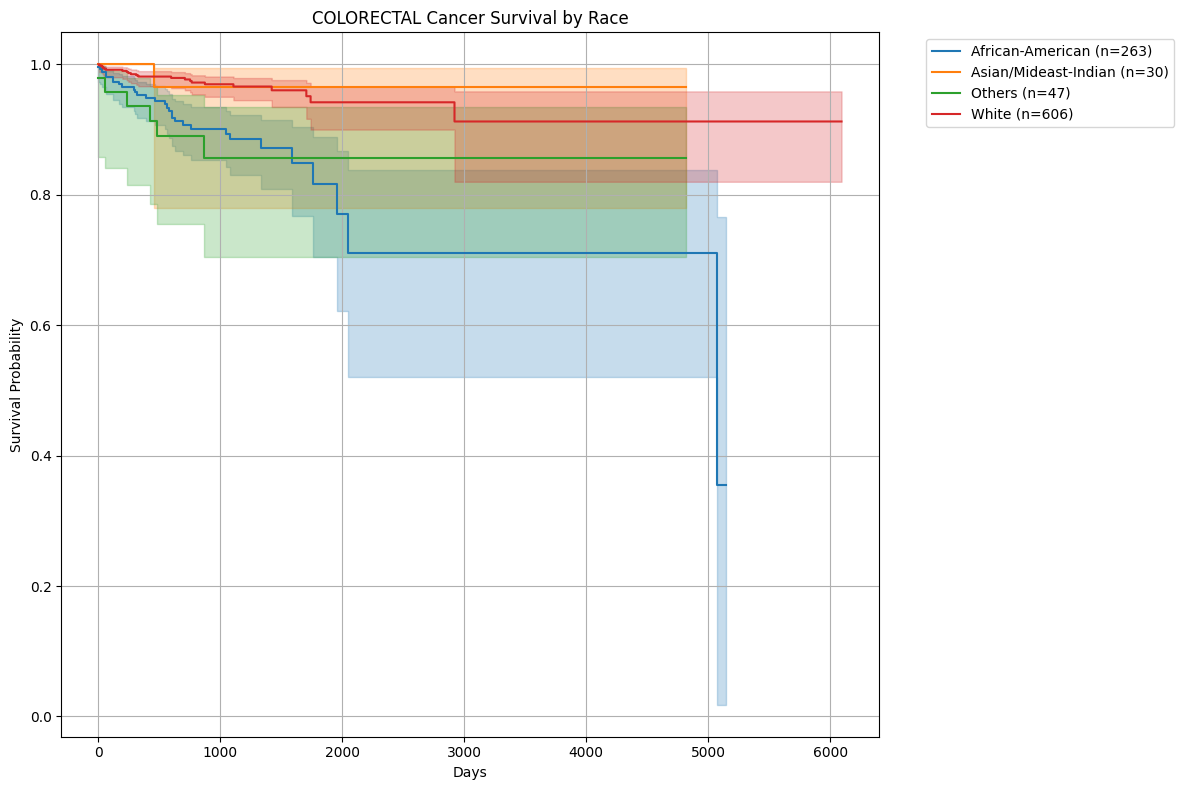

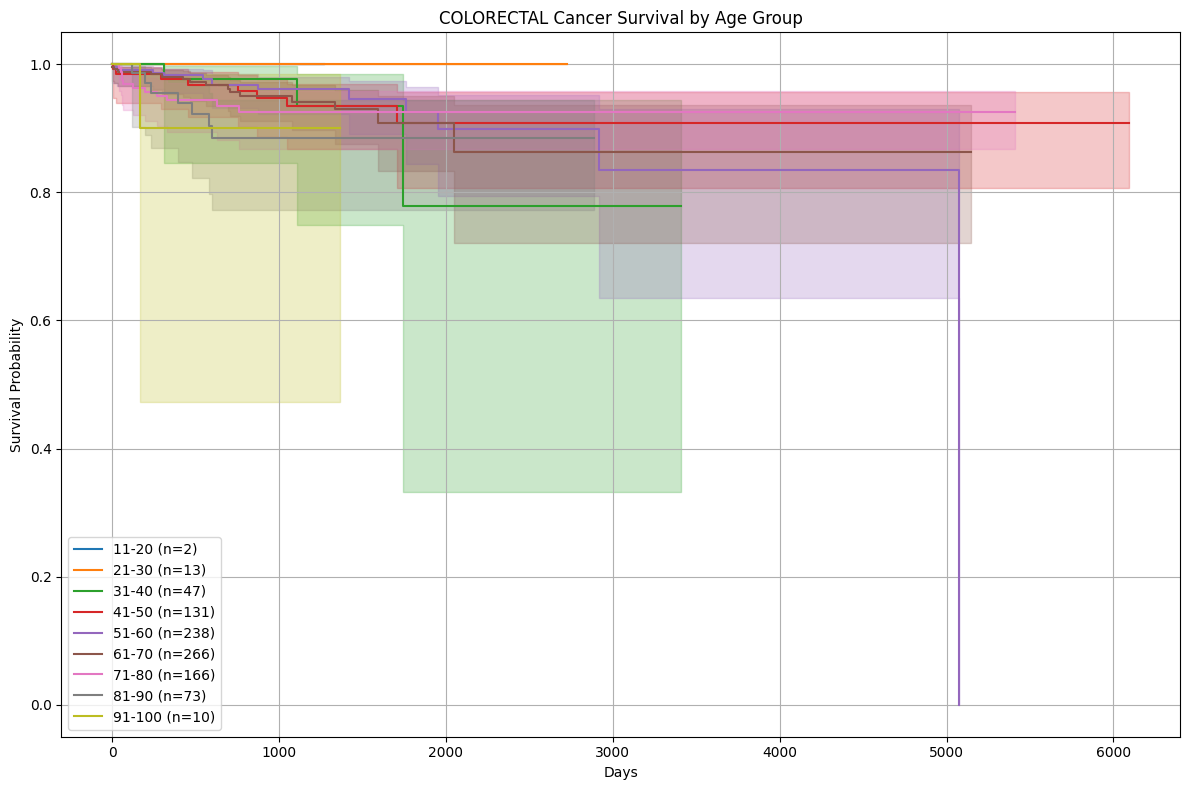


COLORECTAL Cancer Basic Statistics:

Gender Distribution:
sex
Male      523
Female    423
Name: count, dtype: int64

Race Distribution:
race
White                   606
African-American        263
Others                   47
Asian/Mideast-Indian     30
Name: count, dtype: int64

Age Group Distribution:
COLORECTAL_age_group
11-20       2
21-30      13
31-40      47
41-50     131
51-60     238
61-70     266
71-80     166
81-90      73
91-100     10
Name: count, dtype: int64

Survival Statistics:
1-year survival rate: 97.2%
3-year survival rate: 94.1%
5-year survival rate: 90.7%
10-year survival rate: 86.8%
Median survival time: Not reached (survival > 50%)

Patient Summary:
Total patients: 946
Number of deaths: 58
Number of censored: 888

-Generating survival curves for MELANOMA cancer-


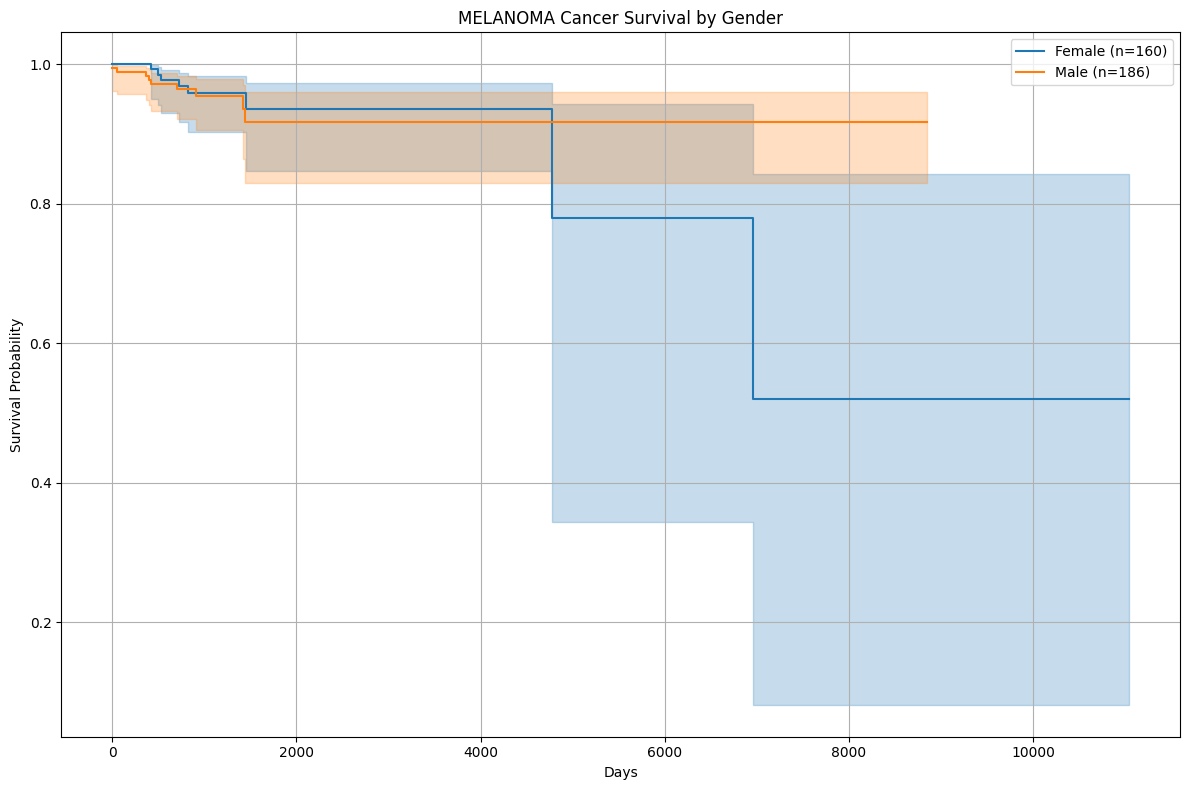

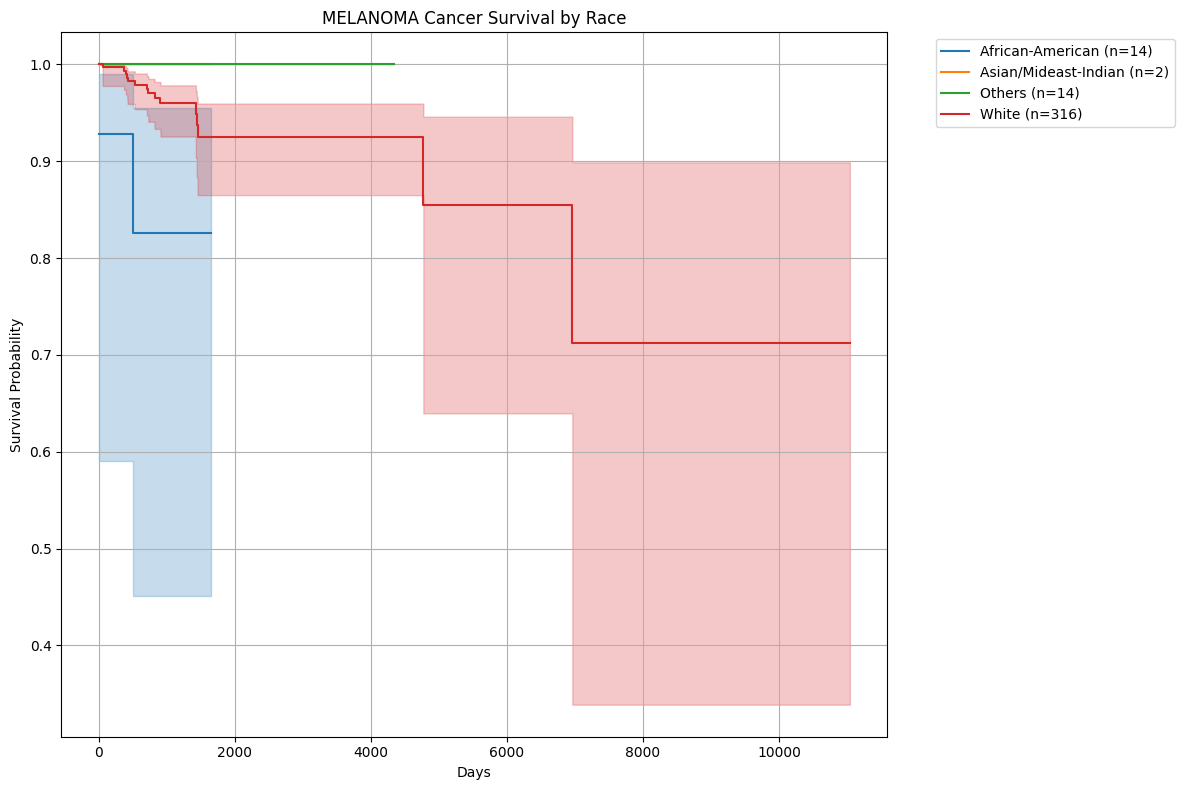

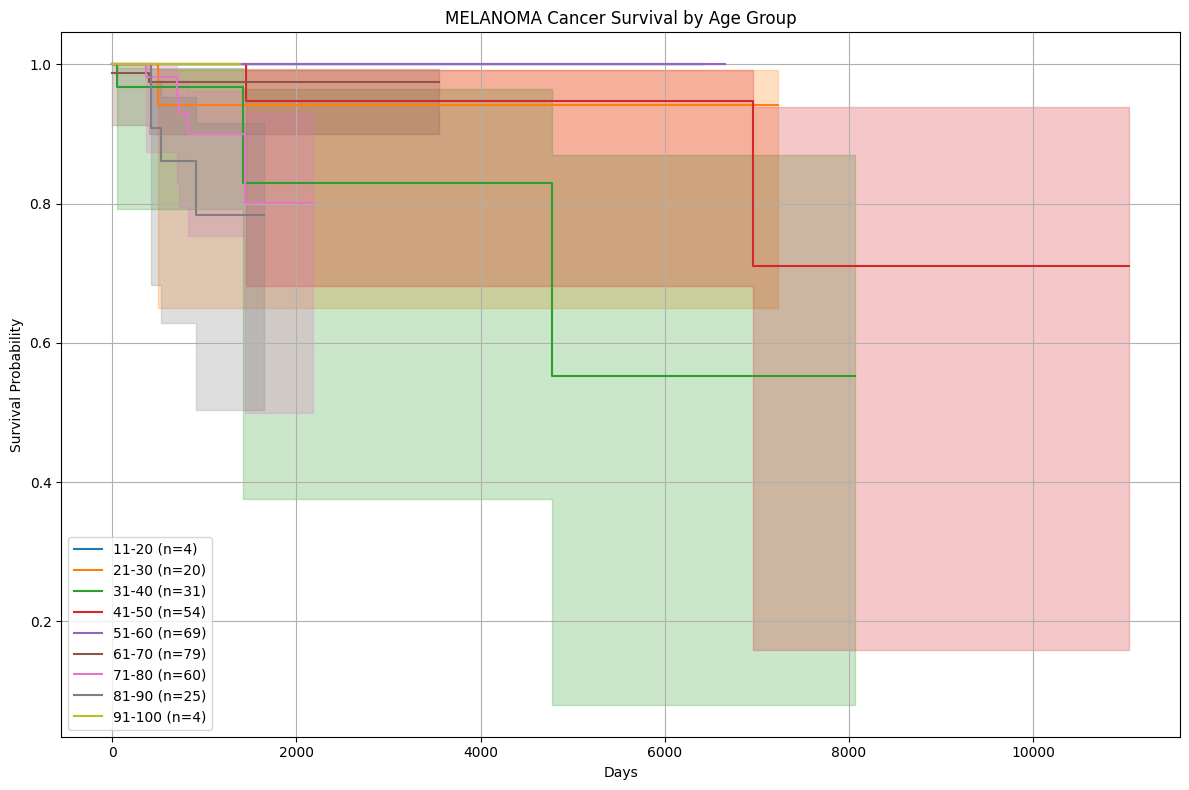


MELANOMA Cancer Basic Statistics:

Gender Distribution:
sex
Male      186
Female    160
Name: count, dtype: int64

Race Distribution:
race
White                   316
Others                   14
African-American         14
Asian/Mideast-Indian      2
Name: count, dtype: int64

Age Group Distribution:
MELANOMA_age_group
11-20      4
21-30     20
31-40     31
41-50     54
51-60     69
61-70     79
71-80     60
81-90     25
91-100     4
Name: count, dtype: int64

Survival Statistics:
1-year survival rate: 99.4%
3-year survival rate: 95.7%
5-year survival rate: 92.5%
10-year survival rate: 92.5%
Median survival time: Not reached (survival > 50%)

Patient Summary:
Total patients: 346
Number of deaths: 17
Number of censored: 329


In [63]:
# 2-4. curves for each cancer type by gender, race, and age group
for cancer in cancer_types:
    if len(cancer_data[cancer]) > 0:
        print(f"\n-Generating survival curves for {cancer} cancer-")
        
        # Gender
        plot_survival_curves(cancer_data, 'sex', 
                           f'{cancer} Cancer Survival by Gender', 
                           cancer)
        
        # Race
        plot_survival_curves(cancer_data, 'race', 
                           f'{cancer} Cancer Survival by Race', 
                           cancer)
        
        # Age group 
        plot_survival_curves(cancer_data, f'{cancer}_age_group', 
                           f'{cancer} Cancer Survival by Age Group', 
                           cancer)
        print(f"\n{cancer} Cancer Basic Statistics:")
        patients = cancer_data[cancer]
        
        print("\nGender Distribution:")
        print(patients['sex'].value_counts())
        
        print("\nRace Distribution:")
        print(patients['race'].value_counts())
        
        print("\nAge Group Distribution:")
        print(patients[f'{cancer}_age_group'].value_counts().sort_index())
        
        kmf = KaplanMeierFitter()
        kmf.fit(patients['duration'], patients['event'])
        
        print("\nSurvival Statistics:")
        surv_1yr = kmf.survival_function_at_times(365).iloc[0]
        surv_3yr = kmf.survival_function_at_times(1095).iloc[0]
        surv_5yr = kmf.survival_function_at_times(1825).iloc[0]
        surv_10yr = kmf.survival_function_at_times(3650).iloc[0]

        print(f"1-year survival rate: {surv_1yr:.1%}")
        print(f"3-year survival rate: {surv_3yr:.1%}")
        print(f"5-year survival rate: {surv_5yr:.1%}")
        print(f"10-year survival rate: {surv_10yr:.1%}")

        median = kmf.median_survival_time_
        if not np.isinf(median):
            print(f"Median survival time: {median:.1f} days")
        else:
            print("Median survival time: Not reached (survival > 50%)")
        
        print(f"\nPatient Summary:")
        print(f"Total patients: {len(patients)}")
        print(f"Number of deaths: {sum(patients['event'])}")
        print(f"Number of censored: {len(patients) - sum(patients['event'])}")

# Section B

In [45]:
def calculate_specific_survival_rate(data, days, condition=None):
    if condition is not None:
        data = data[condition]
    
    if len(data) == 0:
        return np.nan
    
    kmf = KaplanMeierFitter()
    kmf.fit(data['duration'], data['event'])
    try:
        return kmf.survival_function_at_times(days).iloc[0]
    except:
        return np.nan


In [47]:
# 1 and 2
survival_stats = {}
for cancer, patients in cancer_data.items():
    if len(patients) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(patients['duration'], patients['event'])
        ten_year = kmf.survival_function_at_times(3650).iloc[0]
        survival_stats[cancer] = ten_year
        print(f"\n{cancer}:")
        print(f"Number of patients: {len(patients)}")
        print(f"10-year survival rate: {ten_year:.1%}")

sorted_survival = sorted(survival_stats.items(), key=lambda x: x[1], reverse=True)
print(f"\n1. Cancer with highest survival: {sorted_survival[0][0]} ({sorted_survival[0][1]:.1%})")
print(f"\n2. Cancer with lowest survival: {sorted_survival[-1][0]} ({sorted_survival[-1][1]:.1%})")



LUNG:
Number of patients: 1482
10-year survival rate: 81.5%

PANCREAS:
Number of patients: 658
10-year survival rate: 94.3%

THYROID:
Number of patients: 744
10-year survival rate: 98.5%

COLORECTAL:
Number of patients: 946
10-year survival rate: 86.8%

MELANOMA:
Number of patients: 346
10-year survival rate: 92.5%

1. Cancer with highest survival: THYROID (98.5%)

2. Cancer with lowest survival: LUNG (81.5%)


In [49]:
# 3
cancer_counts = df[cancer_types].sum(axis=1)
multiple_cancers = len(df[cancer_counts > 1])
print(f"3. Number of patients with multiple cancers: {multiple_cancers}")

3. Number of patients with multiple cancers: 29


In [51]:
# 4
survival_400_days = {}
for cancer in cancer_types:
    patients = cancer_data[cancer]
    for age_group in patients[f'{cancer}_age_group'].unique():
        if pd.notna(age_group):
            rate = calculate_specific_survival_rate(
                patients[patients[f'{cancer}_age_group'] == age_group],
                400
            )
            if pd.notna(rate):
                survival_400_days[(cancer, age_group)] = rate

min_survival = min(survival_400_days.items(), key=lambda x: x[1])
print(f"4. Lowest survival after 400 days: {min_survival[0][1]} (Cancer: {min_survival[0][0][0]}, Age group: {min_survival[0][0][1]})")


4. Lowest survival after 400 days: 91-100 (Cancer: L, Age group: U)


In [53]:
# 5-20.
specific_questions = [
    # 5. Females with colorectal cancer after 1000 days
    ('COLORECTAL', 1000, lambda x: x['sex'] == 'Female'),
    # 6. Males with lung cancer after 300 days
    ('LUNG', 300, lambda x: x['sex'] == 'Male'),
    # 7. Females with melanoma cancer after 1200 days
    ('MELANOMA', 1200, lambda x: x['sex'] == 'Female'),
    # 8. Males with thyroid cancer after 1500 days
    ('THYROID', 1500, lambda x: x['sex'] == 'Male'),
    # 9. Males with pancreatic cancer after 2200 days
    ('PANCREAS', 2200, lambda x: x['sex'] == 'Male'),
    # 10. African-Americans with colorectal cancer after 2000 days
    ('COLORECTAL', 2000, lambda x: x['race'] == 'African-American'),
    # 11. Whites with lung cancer after 1000 days
    ('LUNG', 1000, lambda x: x['race'] == 'White'),
    # 12. African-Americans with melanoma cancer after 2 years
    ('MELANOMA', 730, lambda x: x['race'] == 'African-American'),
    # 13. Whites with pancreatic cancer after 3 years
    ('PANCREAS', 1095, lambda x: x['race'] == 'White'),
    # 14. Asians with thyroid cancer after 1500 days
    ('THYROID', 1500, lambda x: x['race'] == 'Asian/Mideast-Indian'),
    # 15. Colorectal cancer - lowest survival age group at end of study
    ('COLORECTAL', 3650, None),
    # 16. Lung cancer - highest survival age group at end of study
    ('LUNG', 3650, None),
    # 17. 61-70 age group with melanoma cancer after 5 years
    ('MELANOMA', 1825, lambda x: x['MELANOMA_age_group'] == '61-70'),
    # 18. 21-30 age group with pancreatic cancer after a year
    ('PANCREAS', 365, lambda x: x['PANCREAS_age_group'] == '21-30'),
    # 19. 51-60 age group with thyroid cancer after 2200 days
    ('THYROID', 2200, lambda x: x['THYROID_age_group'] == '51-60'),
    # 20. Race with highest survival across all cancers after 2500 days
    (None, 2500, None)
]


In [55]:
# 5-19 
for i, (cancer, days, condition) in enumerate(specific_questions[:-1], 5):  # Exclude only the last question (20)
    if cancer is not None and condition is not None:
        try:
            rate = calculate_specific_survival_rate(cancer_data[cancer], days, condition)
            print(f"{i}. Survival rate: {rate:.1%}")
        except Exception as e:
            print(f"{i}. Error calculating survival rate: {str(e)}")

5. Survival rate: 94.8%
6. Survival rate: 91.5%
7. Survival rate: 95.9%
8. Survival rate: 97.2%
9. Survival rate: 95.3%
10. Survival rate: 77.1%
11. Survival rate: 90.9%
12. Survival rate: 82.5%
13. Survival rate: 96.5%
14. Survival rate: 92.9%
17. Survival rate: 97.4%
18. Survival rate: 100.0%
19. Survival rate: 98.2%


In [97]:
# 15.1. Colorectal cancer - lowest survival age group -10 years
colorectal_age_survival = {}
for age_group in cancer_data['COLORECTAL'][f'COLORECTAL_age_group'].unique():
    if pd.notna(age_group):
        rate = calculate_specific_survival_rate(
            cancer_data['COLORECTAL'][cancer_data['COLORECTAL'][f'COLORECTAL_age_group'] == age_group],
            3650 # 10 years
        )
        colorectal_age_survival[age_group] = rate

min_colorectal = min(colorectal_age_survival.items(), key=lambda x: x[1] if pd.notna(x[1]) else float('inf'))
print(f"15. Lowest survival age group for colorectal cancer: {min_colorectal[0]}")

15. Lowest survival age group for colorectal cancer: 31-40


In [89]:
# 15.2. Colorectal cancer - lowest survival age group
colorectal_age_survival = {}

for age_group in age_order:
    mask = cancer_data['COLORECTAL'][f'COLORECTAL_age_group'] == age_group
    if mask.sum() > 0:
        patients = cancer_data['COLORECTAL'][mask]
        kmf = KaplanMeierFitter()
        kmf.fit(patients['duration'], patients['event'])
        survival_rate = kmf.survival_function_.values[0]
        colorectal_age_survival[age_group] = survival_rate

if colorectal_age_survival:
    min_group = min(colorectal_age_survival.items(), key=lambda x: x[1])
    print(f"Age group has the lowest survival for colorectal cancer at the end of the study: {min_group[0]}")

Age group has the lowest survival for colorectal cancer at the end of the study: 51-60


In [93]:
# 16. Lung cancer - highest survival age group
lung_age_survival = {}
, '81-90', '91-100']

for age_group in age_order:
   mask = cancer_data['LUNG'][f'LUNG_age_group'] == age_group
   if mask.sum() > 0:
       patients = cancer_data['LUNG'][mask]
       kmf = KaplanMeierFitter()
       kmf.fit(patients['duration'], patients['event'])
       survival_rate = kmf.survival_function_.values[-1]
       lung_age_survival[age_group] = survival_rate

if lung_age_survival:
   max_group = max(lung_age_survival.items(), key=lambda x: x[1])
   print(f"Age group has the highest survival for lung cancer at the end of the study: {max_group[0]}")

Age group has the highest survival for lung cancer at the end of the study: 11-20


In [65]:
# 20. Race with highest survival across all cancers after 2500 days
print("\n20. Race with highest survival across all cancers after 2500 days:")

all_patients = pd.concat([data for data in cancer_data.values()])

race_survival = {}
for race in all_patients['race'].unique():
    mask = all_patients['race'] == race
    if mask.sum() > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(all_patients.loc[mask, 'duration'],
                all_patients.loc[mask, 'event'])
        try:
            survival_rate = kmf.survival_function_at_times(2500).iloc[0]
            n_patients = mask.sum()
            print(f"{race}: {survival_rate:.1%} (n={n_patients})")
            race_survival[race] = survival_rate
        except:
            print(f"Could not calculate survival rate for {race}")

if race_survival:
    best_race = max(race_survival.items(), key=lambda x: x[1])
    print(f"\nRace with highest survival: {best_race[0]} ({best_race[1]:.1%})")


20. Race with highest survival across all cancers after 2500 days:
African-American: 74.4% (n=968)
White: 92.6% (n=2830)
Asian/Mideast-Indian: 92.3% (n=117)
Others: 92.0% (n=261)

Race with highest survival: White (92.6%)
